In [3]:
import numpy as np
import ROOT as root
import os
import matplotlib.pyplot as plt
import math
import time
from mpl_toolkits.mplot3d import Axes3D



from sklearn.cluster import KMeans


Welcome to JupyROOT 6.18/04


In [5]:
dataDir = '/Users/czkaiweb/Research/DisappTrkMLData/converted/'
data_e = np.load(dataDir+'e_DYJets50V3_norm_40x40_nonscaled_tiny.npy')
data_bkg = np.load(dataDir+'bkg_DYJets50V3_norm_40x40_nonscaled_tiny.npy')
test_e = np.load(dataDir+'e_DYJets50V3_norm_40x40_nonscaled_tinyTest.npy')
test_bkg = np.load(dataDir+'bkg_DYJets50V3_norm_40x40_nonscaled_tinyTest.npy')

data = np.concatenate((data_e, data_bkg), axis=0)

In [ ]:
def plot_event(x):
    
    fig, axs = plt.subplots(1,5,figsize=(10,10))
    
    for i in range(5):
        axs[i].imshow(x[i,:,:],cmap='gray')
    
    axs[0].set_title("None")
    axs[1].set_title("EE - EB")
    axs[2].set_title("ES")
    axs[3].set_title("HCAL")
    axs[4].set_title("CSC - DT - RPC")
    
    plt.show()

plot_event(data_e[3])

In [6]:
def ExpoConv2D(input, parameters):
    if len(parameters) == 0:
        parameters = [1.0,1.0]
    if len(parameters) != 2:
        raise Exception('Number of parameter should be 2. The size of parameter was: {}'.format(parameters.size))
    nX,nY = input.shape
    a,b = parameters
    result = 0.0
    for ix in range(nX):
        for iy in range(nY):
            distance = math.sqrt( a*a*(ix-(nX+1)/2.0)*(ix-(nX+1)/2.0) + b*b*(iy-(nY+1)/2.0)*(iy-(nY+1)/2.0))
            weight = math.exp(-1.0*distance)
            result += math.fabs(input[ix][iy])*weight
    return result

def GausConv2D(input, parameters):
    if len(parameters) == 0:
        parameters = [0.0,0.0,1.0,1.0]
    if len(parameters) != 4:
        raise Exception('Number of parameter should be 4. The size of parameter was: {}'.format(parameters.size))
    nX,nY = input.shape
    x_c,y_c,sig_x,sig_y = parameters
    result = 0.0
    for ix in range(nX):
        for iy in range(nY):
            coeff = 1.0/(2*math.pi*sig_x*sig_y)
            kernel = math.exp(-1.0/2*( (ix-(nX+1)/2.0-x_c)*(ix-(nX+1)/2.0-x_c)/(sig_x*sig_x)+ (iy-(nY+1)/2.0-y_c)*(iy-(nY+1)/2.0-y_c)/(sig_y*sig_y)))
            result += math.fabs(input[ix][iy])*coeff*kernel
    return result

def KernelConv2D(input, kernel, parameters):
    if kernel == "expo":
        result = ExpoConv2D(input,parameters)
    if kernel == "gaus":
        result = GausConv2D(input,parameters)
    return result   

def ImageConv2D(input, kernel, parameters = [] ):
    nEvent,nType,nEta,nPhi = input.shape
    result = []
    for iEvent in range(nEvent):
        charactor = []
        for iType in [1,3,4]:
            conv = KernelConv2D(input[iEvent,iType,:,:],kernel,parameters)
            charactor.append(conv)
        result.append(charactor)
    return result


In [23]:
# kernel options: [expo, gaus]
# parameters for kernels:

CovVector = ImageConv2D(data,"expo")
GaussVector = ImageConv2D(data, "gaus",[0.0,0.0,5.0,5.0])



In [7]:
elecClusterExpo = ImageConv2D(data_e,"expo")
bkgClusterExpo  = ImageConv2D(data_bkg,"expo")

elecClusterGauss = ImageConv2D(data_e,"gaus",[0.0,0.0,5.0,5.0])
bkgClusterGauss  = ImageConv2D(data_bkg,"gaus",[0.0,0.0,5.0,5.0])

In [19]:

def LayerProjPlot(input_list):
    color=["r","b","g","c","m","y","k","w"]
    fig, axs = plt.subplots(1,3,figsize=(30,10))
    for index,input in enumerate(input_list):
        axs[0].scatter(np.array(input)[:,0],np.array(input)[:,1],c=color[index],s=1)
        axs[0].set_title("ECAL-HCAL")
        axs[1].scatter(np.array(input)[:,0],np.array(input)[:,2],c=color[index],s=1)
        axs[1].set_title("ECAL-MUON")
        axs[2].scatter(np.array(input)[:,0],np.array(input)[:,2],c=color[index],s=1)
        axs[2].set_title("HCAL-MUON")
    plt.show()
    
def LayerPlot3D(input_list):
    color=["r","b","g","c","m","y","k","w"]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for index,input in enumerate(input_list):
        ax.scatter(np.array(input)[:,0],np.array(input)[:,1],np.array(input)[:,2],c=color[index],s=1)
    plt.show()
        

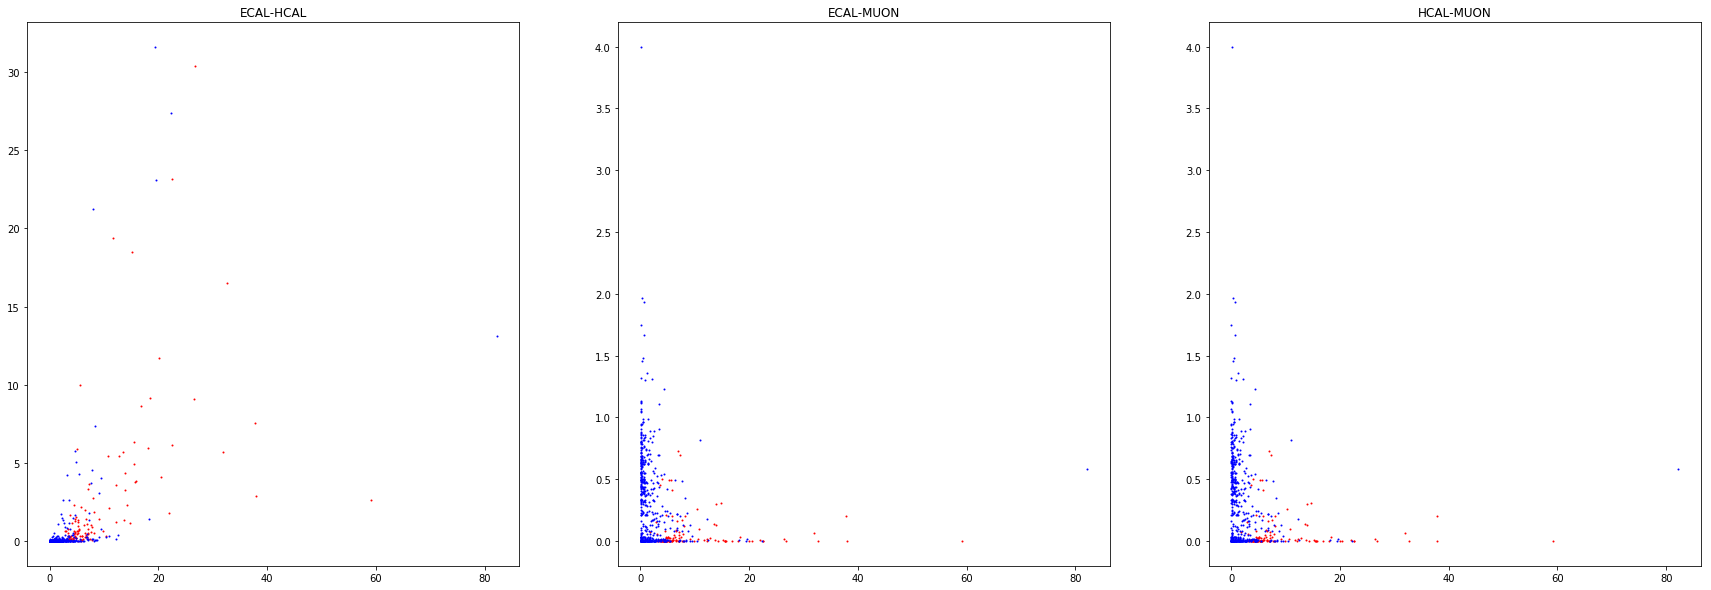

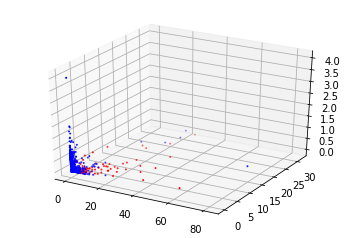

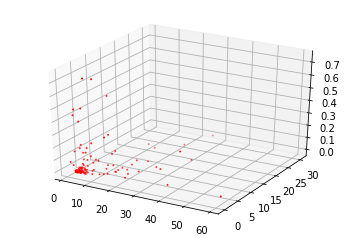

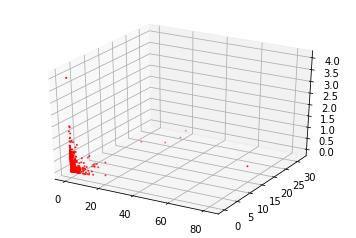

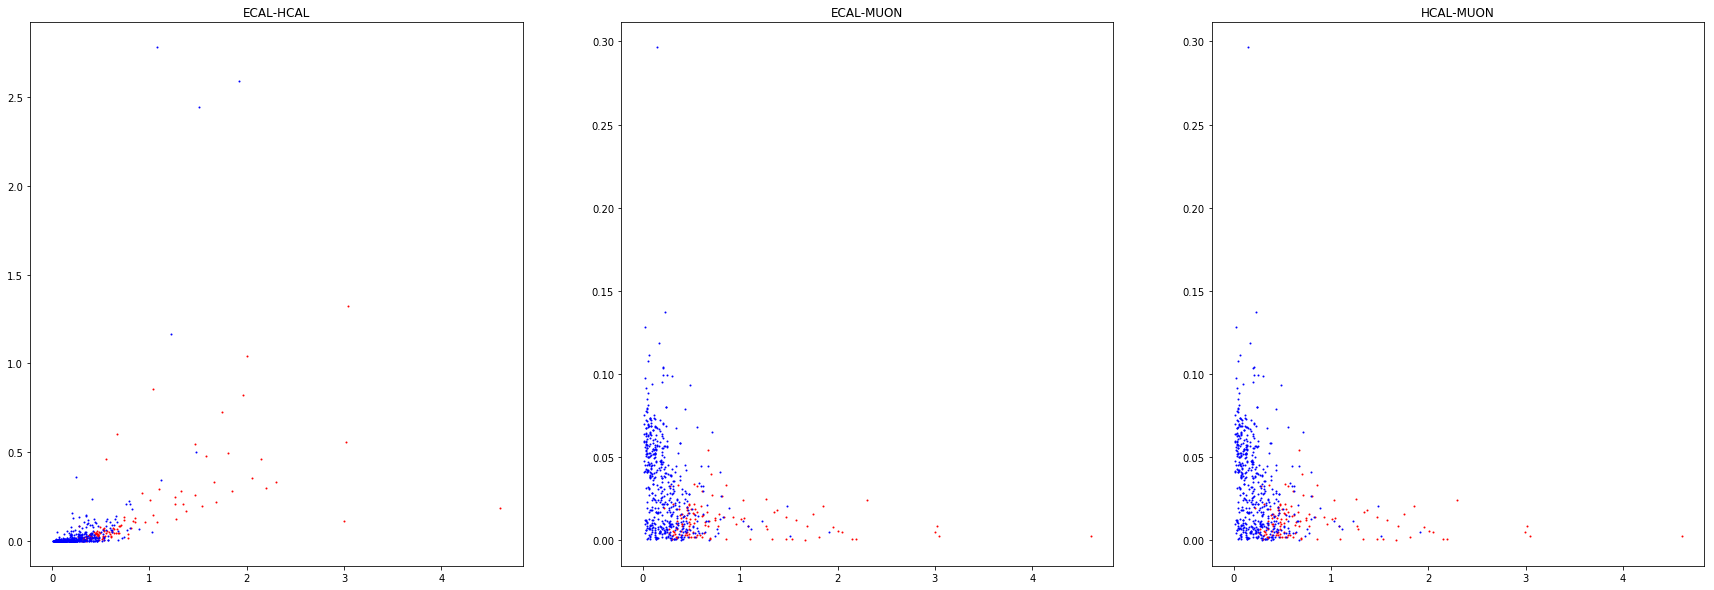

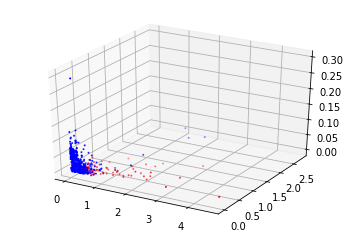

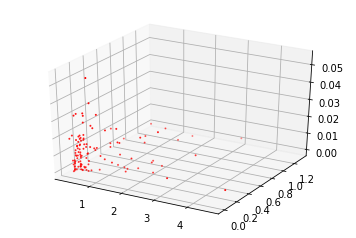

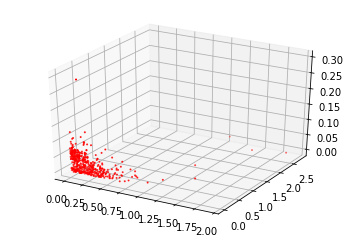

In [21]:
elecClusterExpoArray = np.array(elecClusterExpo)
bkgClusterExpoArray = np.array(bkgClusterExpo)
# ECal vs HCal
#plt.scatter(elecClusterExpoArray[:,0],elecClusterExpoArray[:,1],c="r")
#plt.scatter(bkgClusterExpoArray[:,0],bkgClusterExpoArray[:,1],c="b")
#plt.show()
LayerProjPlot([elecClusterExpo,bkgClusterExpo])
LayerPlot3D([elecClusterExpo,bkgClusterExpo])

LayerPlot3D([elecClusterExpo])
LayerPlot3D([bkgClusterExpo])

LayerProjPlot([elecClusterGauss,bkgClusterGauss])
LayerPlot3D([elecClusterGauss,bkgClusterGauss])

LayerPlot3D([elecClusterGauss])
LayerPlot3D([bkgClusterGauss])

In [22]:
print type(CovVector)
x_train = np.array(CovVector)
start = time.time()
kmeans = KMeans(n_clusters=4, random_state=0).fit(x_train)
end = time.time()
print"Time consuming: ",(end - start)
print type(kmeans)
print kmeans.labels_
print kmeans.cluster_centers_

x_train_gauss = np.array(GaussVector)
start = time.time()
kmeans_gauss = KMeans(n_clusters=3, random_state=0).fit(x_train_gauss)
end = time.time()
print "Time consuming: ", (end - start)
print kmeans_gauss.labels_
print kmeans_gauss.cluster_centers_

NameError: name 'CovVector' is not defined

In [ ]:
print data_e.shape
print data_bkg.shape

start = time.time()

x_validate = np.array(ImageConv2D(test_e,"expo"))
predict_e = kmeans.predict(x_validate)


x_validate_bkg = np.array(ImageConv2D(test_bkg,"expo"))
predict_bkg = kmeans.predict(x_validate_bkg)

end = time.time()
print "Time consuming: ",(end - start)


print predict_e
print predict_bkg

from collections import Counter
c = Counter(predict_e)
print [(i, c[i]*1.0/ len(predict_e) * 100.0) for i in c]

c = Counter(predict_bkg)
print [(i, c[i]*1.0/ len(predict_bkg) * 100.0) for i in c]


In [ ]:
start = time.time()

x_validate = np.array(ImageConv2D(test_e,"gaus",[0.0,0.0,5.0,5.0]))
predict_e = kmeans_gauss.predict(x_validate)


x_validate_bkg = np.array(ImageConv2D(test_bkg,"gaus",[0.0,0.0,5.0,5.0]))
predict_bkg = kmeans_gauss.predict(x_validate_bkg)

end = time.time()
print "Time consuming: ",(end - start)


print predict_e
print predict_bkg

from collections import Counter
c = Counter(predict_e)
print [(i, c[i]*1.0/ len(predict_e) * 100.0) for i in c]

c = Counter(predict_bkg)
print [(i, c[i]*1.0/ len(predict_bkg) * 100.0) for i in c]